<a href="https://colab.research.google.com/github/cicbeast/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module1-statistics-probability-and-inference/LS_DS_131_Statistics_Probability_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 1 Sprint 3 Assignment 1*

# Apply the t-test to real data

Your assignment is to determine which issues have "statistically significant" differences between political parties in this [1980s congressional voting data](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records). The data consists of 435 instances (one for each congressperson), a class (democrat or republican), and 16 binary attributes (yes or no for voting for or against certain issues). Be aware - there are missing values!

Your goals:

1. Load and clean the data (or determine the best method to drop observations when running tests)
2. Using hypothesis testing, find an issue that democrats support more than republicans with p < 0.01

**Adoption-of-the-budget resolution**

3. Using hypothesis testing, find an issue that republicans support more than democrats with p < 0.01

**Crime...though I assume they mean crime spending, or some kind of crime bill**

4. Using hypothesis testing, find an issue where the difference between republicans and democrats has p > 0.1 (i.e. there may not be much of a difference)

**Water Project Cost Sharing**

Note that this data will involve *2 sample* t-tests, because you're comparing averages across two groups (republicans and democrats) rather than a single group against a null hypothesis.

Stretch goals:

1. Refactor your code into functions so it's easy to rerun with arbitrary variables
2. Apply hypothesis testing to your personal project data (for the purposes of this notebook you can type a summary of the hypothesis you formed and tested)

In [0]:
### YOUR CODE STARTS HERE

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import style
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel

%matplotlib inline

In [2]:
# Let's get our data

data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
df = pd.read_csv(data_url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [3]:
# Now let's add in our columns names from the metadata

colnames = ['Class name', 'handicapped-infants', 'water-project-cost-sharing', 
            'adoption-of-the-budget-resolution', 'physician-fee-freeze', 
            'el-salvador-aid', 'religious-groups-in-schools',
            'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
            'immigration', 'synfuels-corporation-cutback', 'education-spending',
            'superfund-right-to-sue', 'crime', 'duty-free-exports',
            'export-administration-act-south-africa']

df = pd.read_csv(data_url, header=None, names=colnames)
df.head()


,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y


In [4]:
# And let's make sure that we have all the instances we expect to

df.shape

(435, 17)

In [5]:
# We can see question marks in the data
# From the metadata we know that ? was used when answers weren't y or n
# Let's check that

df.isin(['?'])

,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True


In [6]:
# Also, let's make sure that there are no other random elements in our data
df.nunique()

Class name                                2
handicapped-infants                       3
water-project-cost-sharing                3
adoption-of-the-budget-resolution         3
physician-fee-freeze                      3
el-salvador-aid                           3
religious-groups-in-schools               3
anti-satellite-test-ban                   3
aid-to-nicaraguan-contras                 3
mx-missile                                3
immigration                               3
synfuels-corporation-cutback              3
education-spending                        3
superfund-right-to-sue                    3
crime                                     3
duty-free-exports                         3
export-administration-act-south-africa    3
dtype: int64

In [7]:
# We know that there are ? values in the dataframe
# Sum would be more useful though

df.isin(['?']).sum()

Class name                                  0
handicapped-infants                        12
water-project-cost-sharing                 48
adoption-of-the-budget-resolution          11
physician-fee-freeze                       11
el-salvador-aid                            15
religious-groups-in-schools                11
anti-satellite-test-ban                    14
aid-to-nicaraguan-contras                  15
mx-missile                                 22
immigration                                 7
synfuels-corporation-cutback               21
education-spending                         31
superfund-right-to-sue                     25
crime                                      17
duty-free-exports                          28
export-administration-act-south-africa    104
dtype: int64

In [8]:
# So we know that there are only 5 unique elements in our dataframe
# We also know that 2 of those are only found in the first column
# We can treat 'y,n,?' as boolean, with ? being a NaN value.

df = pd.read_csv(data_url, header=None, names=colnames, na_values='?')
df.head(10)


,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y
5,democrat,n,y,y,n,y,y,n,n,n,n,n,n,y,y,y,y
6,democrat,n,y,n,y,y,y,n,n,n,n,n,n,NaN,y,y,y
7,republican,n,y,n,y,y,y,n,n,n,n,n,n,y,y,NaN,y
8,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,y
9,democrat,y,y,y,n,n,n,y,y,y,n,n,n,n,n,NaN,NaN


In [9]:
# Now let's replace the y and n with 1 and -1, so we can do some stats work
df = df.replace(['y','n'], [1,-1])
df.head(10)

,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,NaN,1.0,1.0,1.0,-1.0,1.0
1,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
3,democrat,-1.0,1.0,1.0,-1.0,NaN,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
4,democrat,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
6,democrat,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,1.0,1.0,1.0
7,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,NaN,1.0
8,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0
9,democrat,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN


In [10]:
# Now lets separate the democrats and republicans
dems = df[df['Class name'] == 'democrat']
reps = df[df['Class name'] == 'republican']

dems.head(10)

,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
3,democrat,-1.0,1.0,1.0,-1.0,NaN,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
4,democrat,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
6,democrat,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,1.0,1.0,1.0
9,democrat,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN
12,democrat,-1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,NaN,NaN
13,democrat,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,-1.0,-1.0,1.0,NaN
16,democrat,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0,NaN,1.0,1.0,1.0,NaN,-1.0,-1.0,1.0
17,democrat,1.0,NaN,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0


In [11]:
# and the republicans
reps.head(10)

,Class name,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,NaN,1.0,1.0,1.0,-1.0,1.0
1,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,NaN
7,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,NaN,1.0
8,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0
10,republican,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,NaN,1.0,1.0,-1.0,-1.0
11,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,1.0,1.0,NaN,NaN
14,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,NaN,-1.0,NaN
15,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,NaN,-1.0,NaN
18,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,1.0,1.0,-1.0,-1.0
28,republican,1.0,-1.0,-1.0,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0


In [12]:
# I don't actually need the class name in my separated dataframes
colheaders = colnames[1:]

dems = dems[colheaders]
reps = reps[colheaders]
dems.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
2,NaN,1.0,1.0,NaN,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
3,-1.0,1.0,1.0,-1.0,NaN,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
4,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,NaN,1.0,1.0,1.0,1.0
5,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,1.0
6,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,1.0,1.0,1.0


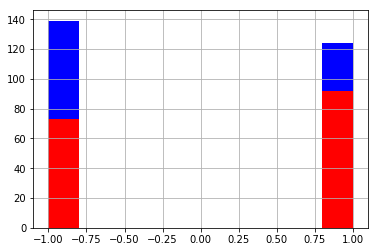

In [13]:
# Ok, so let's visualize...immigration

dems['immigration'].hist(color='b')
reps['immigration'].hist(color='r')

In [14]:
# and let's test immigration per our threshhold 
d_imm = dems['immigration']
r_imm = reps['immigration']

# We have to set equal_var=False as we need a 2 sample t-test
_, pvalue = ttest_ind(d_imm, r_imm, equal_var=False, nan_policy='omit')
print(pvalue)

0.0831850890724641


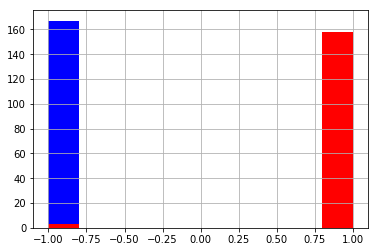

In [15]:
# No luck, let's visualize crime, this should suit our purposes better

dems['crime'].hist(color='b')
reps['crime'].hist(color='r')

In [16]:
# Dem mean is negative, while republican mean is positive
# Republicans support, while democrats don't
# Let's t-test crime
d_crime = dems['crime']
r_crime = reps['crime']
_, pvalue = ttest_ind(d_crime, r_crime, equal_var=False, nan_policy='omit')
print(pvalue)

6.862816276906464e-58


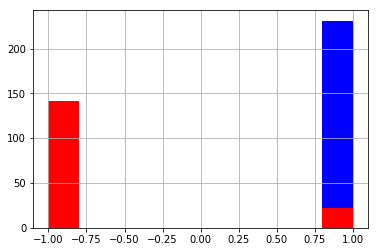

In [17]:
# Now let's look at the adoption of the budget topic
dems['adoption-of-the-budget-resolution'].hist(color='b')
reps['adoption-of-the-budget-resolution'].hist(color='r')

In [19]:
# Now we'll t-test 
d_bdgt = dems['adoption-of-the-budget-resolution']
r_bdgt = reps['adoption-of-the-budget-resolution']
_, pvalue = ttest_ind(d_bdgt, r_bdgt, equal_var=False, nan_policy='omit')
print(pvalue)

1.9467037396513764e-69


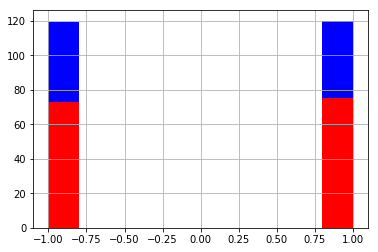

In [20]:
# Now let's look at the adoption of the budget topic
dems['water-project-cost-sharing'].hist(color='b')
reps['water-project-cost-sharing'].hist(color='r')

In [21]:
# I've got a good feeling about this
d_wtr = dems['water-project-cost-sharing']
r_wtr = reps['water-project-cost-sharing']
_, pvalue = ttest_ind(d_wtr, r_wtr, equal_var=False, nan_policy='omit')
print(pvalue)

0.9291867875225105


In [0]:
# Stretch Goal
# There is only so much we can refactor, as the Attributes are not in their own file
# But we can define a function to be more efficient
# we already have colheaders as the attributes for our groups dems and reps

X = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
colnames = ['Class name', 'handicapped-infants', 'water-project-cost-sharing', 
            'adoption-of-the-budget-resolution', 'physician-fee-freeze', 
            'el-salvador-aid', 'religious-groups-in-schools',
            'anti-satellite-test-ban', 'aid-to-nicaraguan-contras', 'mx-missile',
            'immigration', 'synfuels-corporation-cutback', 'education-spending',
            'superfund-right-to-sue', 'crime', 'duty-free-exports',
            'export-administration-act-south-africa']
def plotpval(X):
  headers = colnames[1:]
  df = pd.read_csv(X, header=None, names=colnames, na_values='?').replace(['y','n'], [1,-1]) 
  for names in headers:
    group1 = df[df['Class name'] == 'democrat'].drop(columns=['Class name'])[names]
    group2 = df[df['Class name'] == 'republican'].drop(columns=['Class name'])[names]
    group1.hist(color='b')
    group2.hist(color='r')
    _, pvalue = ttest_ind(group1, group2, equal_var=False, nan_policy='omit')
    plt.title(f'Feature: {names}. P-value: {pvalue:.3f}')
    plt.figure()

  

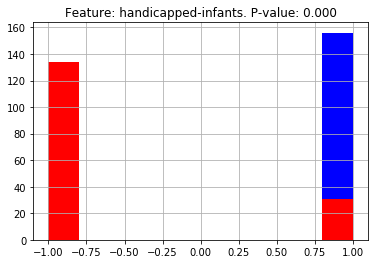

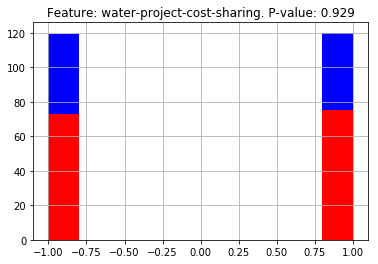

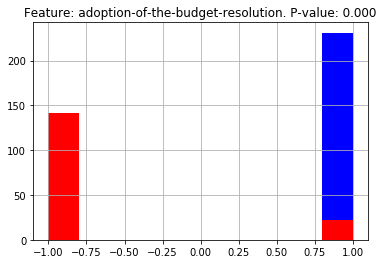

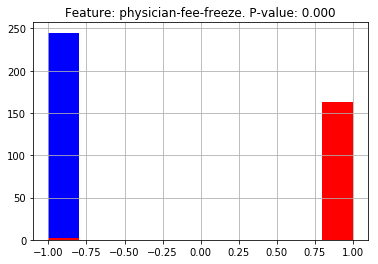

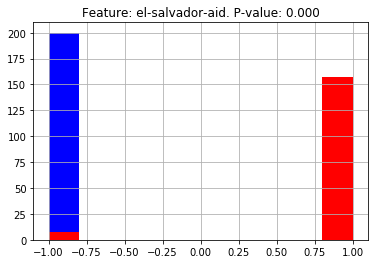

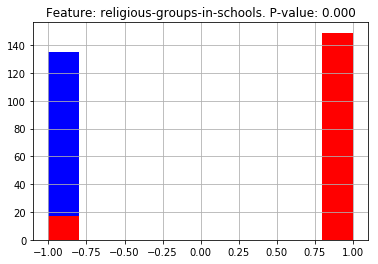

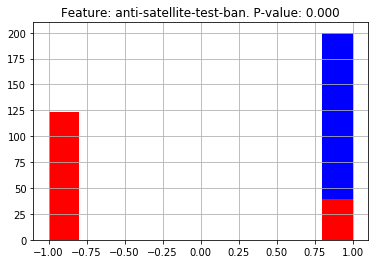

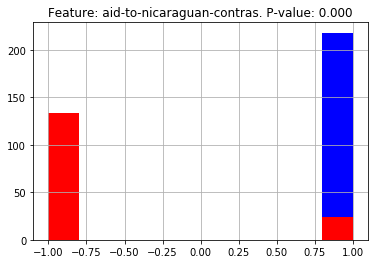

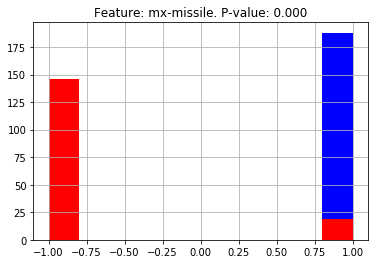

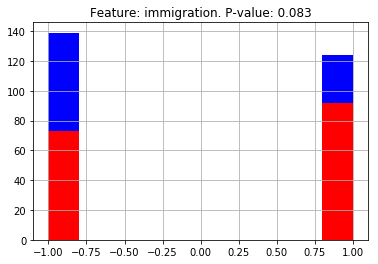

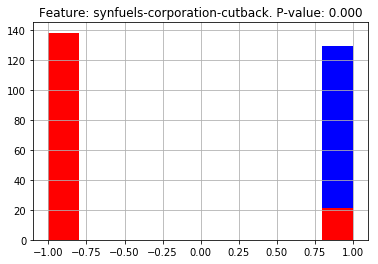

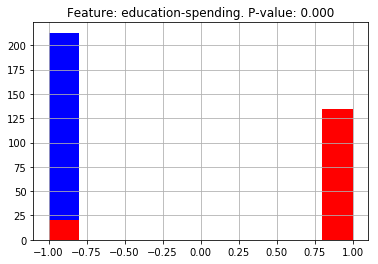

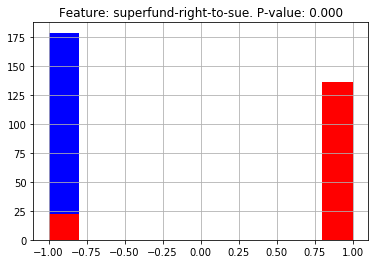

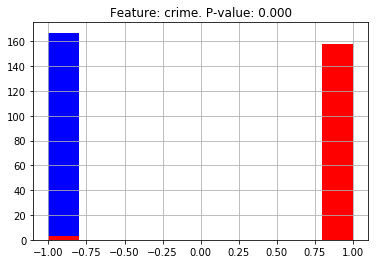

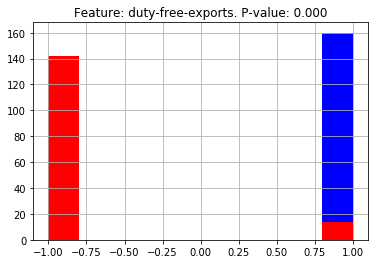

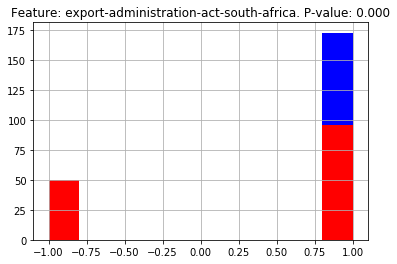

<Figure size 432x288 with 0 Axes>

In [23]:
plotpval(X)